## Data Loading
Let's load the data and take a look into what is in there and how we can use it

In [41]:
#Install packages needed
!pip install -r requirements.txt

In [42]:
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
%matplotlib inline

lets load the data from the csv file generated by the scraper

In [43]:
df = pd.read_csv('./get_data/crawl_data.csv')
brands = pd.DataFrame(df.brand.unique()).sort_values(0).reset_index(drop=True)
display(brands)
print('Nº of different engines %s' % len(df.engine.unique()))
df.info()


,0
0,Alfa Romeo
1,Audi
2,BAIC
3,BMW
4,BYD
5,Brilliance
6,Changan
7,Chery
8,Chevrolet
9,Chrysler


Nº of different engines 308
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 16 columns):
brand           2015 non-null object
color           2015 non-null object
engine          1723 non-null object
fuel            1732 non-null object
id              2015 non-null object
image_urls      2015 non-null object
images          2015 non-null object
location        2015 non-null object
mileage         2015 non-null int64
model           2015 non-null object
onlyOwner       1282 non-null object
price           2015 non-null object
steering        2015 non-null object
traction        1347 non-null object
transmission    2015 non-null object
year            2015 non-null int64
dtypes: int64(2), object(14)
memory usage: 252.0+ KB


There is a lot of different type of engines, they are all in different formats (some ar in liters others in C.C),  and some don't even have that, they just put the name.

Because of this there is not an accesible way to make this information reliable so I choose to delete it.

In [44]:
df = df.drop(columns=['engine', 'image_urls', 'images'])
display(df.head())

,brand,color,fuel,id,location,mileage,model,onlyOwner,price,steering,traction,transmission,year
0,Chevrolet,Gris,Gasolina,MCO478495637,El vehículo está en Normandía Occidental - Eng...,85000,Optra,NaN,15.750.000,Hidráulica,NaN,Mecánica,2007
1,BMW,Blanco,Gasolina,MCO473571184,El vehículo está en Calasanz - Medellín - Anti...,170000,Serie 3,No,13.500.000,Hidráulica,4x2,Automática,1993
2,Chevrolet,Blanco,Gasolina,MCO475239610,El vehículo está en Normandía - Engativa - Bog...,228000,Astra,No,10.900.000,Hidráulica,4x2,Mecánica,2001
3,Renault,Negro,Gasolina,MCO478496049,El vehículo está en Normandía Occidental - Eng...,85432,Logan,Sí,16.350.000,Hidráulica,NaN,Mecánica,2010
4,Mercedes Benz,Azul,NaN,MCO479310149,El vehículo está en Belmira - Usaquén - Bogotá...,35000,Clase C,NaN,46.950.000,Hidráulica,NaN,Automática,2011


next variable to be deal with is the location, this starts with *El vehículo está en* wich needs to be removed, and its also separated by hyphens that also need to be removed

In [45]:
def clean_location(locations, starts_with='El vehículo está en ',):
    location_only_places = locations.str.replace(starts_with, '')
    locations_split = location_only_places.str.split('-')
    location_reverse = locations_split.apply(reversed).apply(list)
    return location_reverse

def get_state_city(location):
    return pd.DataFrame(location.values.tolist())[[0,1]]
    
loc_temp = clean_location(df.location)
df_locations = get_state_city(loc_temp)
df_locations.columns = ['State', 'City']
df = pd.concat([df,df_locations], axis=1)
df = df.drop(columns=['location'])
df = df.set_index('id')

Now lets do some data exploration.

The first thing its see the distribution of our data. One that interest me its how many samples of each car and models do we have

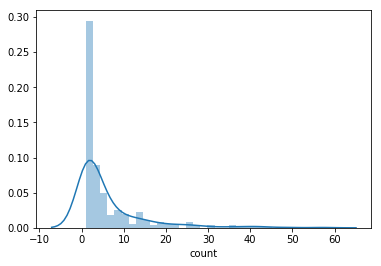

In [46]:
sns.distplot(df.groupby(['brand','model']).size().reset_index().rename(columns={0: 'count'})['count']);

As expected this distribution its highly skewed, which means that we have an over representation of some car and models and under representation of other. This makes sense since some cars an brands are more popular in the market than others.

In [47]:
df['price'] = df['price'].apply(lambda x: x.replace('.', '')).astype(int)
print('Mean   {}'.format(df['price'].mean()))
print('STD    {}'.format(df['price'].std()))
print('Median {}'.format(df['price'].median()))
print('IQR    {}'.format(scipy.stats.iqr(df['price'])))

Mean   53333459.30322581
STD    45545932.66447291
Median 40500000.0
IQR    36900000.0


The standard deviation its quite large compare to the mean, plus the fact that the mean its well above the median leads me to believe that there multiple outliers, to confirm this let's lock a boxplot

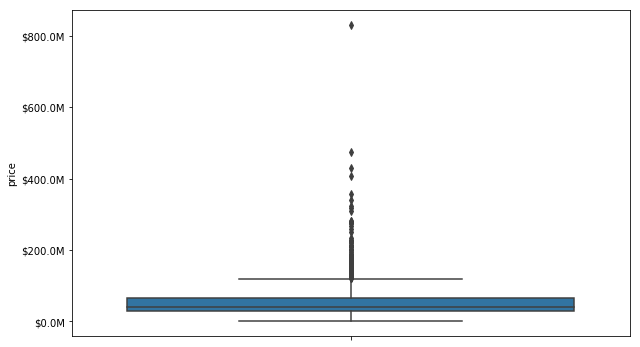

In [48]:
#plt.hist(df['price'], density=True, alpha=0.7)
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)
plt.figure(figsize=(10,6));

ax = sns.boxplot(y='price', data=df);
ax.yaxis.set_major_formatter(formatter);

That its interesting, there seams to be a large number of *"outliers"*, lets see at least the ones over the 0.99 quantile

In [49]:
df[df['price'] > df['price'].quantile(0.99)]

,brand,color,fuel,mileage,model,onlyOwner,price,steering,traction,transmission,year,State,City
id,,,,,,,,,,,,,
MCO479333465,Toyota,Blanco,Diesel,15,Sahara,Sí,323000000,Hidráulica,4x4,Automática,2017,Bogotá D.c.,Usaquén
MCO478654013,BMW,Blanco,NaN,12000,X5,NaN,268000000,Hidráulica,NaN,Automática,2016,Norte De Santander,Cúcuta
MCO477641016,Porsche,Blanco,Gasolina,39001,Macan,Sí,280000000,Hidráulica,4x4,Automática,2015,Bogotá D.c.,Usaquén
MCO479001130,Toyota,Blanco,Diesel,1,Sahara,Sí,407000000,Asistida,4x4,Automática,2019,Bogotá D.c.,Bogota
MCO478826247,Land Rover,Blanco,Diesel,8000,Discovery,Sí,258000000,Hidráulica,4x4,Automática,2017,Bogotá D.c.,Usaquén
MCO480149196,Toyota,Negro,Diesel,1,Prado,Sí,310000000,Asistida,4x4,Automática,2019,Bogotá D.c.,Bogota
MCO480003109,Toyota,Blanco,Diesel,150,Sahara,Sí,275000000,Hidráulica,4x4,Automática,2015,Bogotá D.c.,Bogota
MCO480643751,Toyota,Blanco,Diesel,11000,LC200,Sí,318000000,Hidráulica,4x4,Automática,2016,Bogotá D.c.,Suba
MCO480644775,Porsche,Blanco,Gasolina,15600,Macan,Sí,340000000,Asistida,NaN,Automática,2015,Bogotá D.c.,Usaquén


As expected all this cars are considered luxury cars, which makes sense why this cars are in this price range,
Now the next question is, what happen with the other extreme, the incredibly cheap ones, lets see what they are

In [50]:
df[df['price'] < df['price'].quantile(0.01)]

,brand,color,fuel,mileage,model,onlyOwner,price,steering,traction,transmission,year,State,City
id,,,,,,,,,,,,,
MCO475707684,Volkswagen,Verde,Gasolina,10000,Escarabajo,No,6500000,Mecánica,4x2,Mecánica,1966,Antioquia,Medellín
MCO475157623,Peugeot,Vinotinto,NaN,266066,306,NaN,7200000,Hidráulica,NaN,Mecánica,1998,Cundinamarca,Soacha
MCO474227263,Toyota,Blanco,Diesel,0,Sahara,NaN,154000,Hidráulica,4x4,Automática,2018,Bogotá D.c.,Bogota
MCO474849385,Mazda,Plateado,Gasolina,160000,Matsuri,No,9200000,Hidráulica,4x2,Mecánica,1995,Antioquia,Envigado
MCO480056635,Chevrolet,Verde,NaN,207056,Corsa,No,7900000,Hidráulica,4x2,Mecánica,1997,Valle Del Cauca,Cartago
MCO480398137,Nissan,Vinotinto,Gasolina,257000,Sentra,No,7000000,Hidráulica,NaN,Automática,1995,Bogotá D.c.,Suba
MCO474917701,Toyota,Blanco,Diesel,0,Prado,NaN,107000,Asistida,4x4,Automática,2018,Magdalena,Santa Marta (distrito Turistico Cultural E His...
MCO480606551,Renault,Rojo,Gasolina,102000,R9,Sí,8300000,Asistida,4x2,Mecánica,1997,Bogotá D.c.,Kennedy
MCO481058029,Chevrolet,Blanco,NaN,60843,Sonic,NaN,29500,Hidráulica,NaN,Mecánica,2014,Valle Del Cauca,Cali


In this situation we see something slightly different, we observe a list of cars, some of which are known to be economic,
but there are also luxury cars that have been wrongly priced.

Now lets look at the mileage

Mileage (in Kms)
Mean   70192.9746898263
STD    58524.182317986575
Median 60000.0
IQR    63000.0
Skewness 2.441286621970906
Kurtosis 12.715806775042392


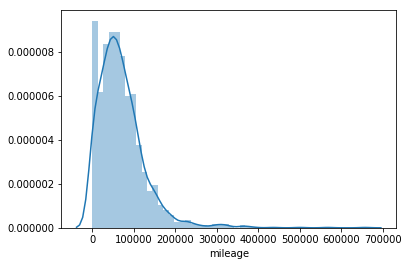

In [51]:
print('Mileage (in Kms)')
print('Mean   {}'.format(df['mileage'].mean()))
print('STD    {}'.format(df['mileage'].std()))
print('Median {}'.format(df['mileage'].median()))
print('IQR    {}'.format(scipy.stats.iqr(df['mileage'])))

print('Skewness {}'.format(scipy.stats.skew(df['mileage'])))
print('Kurtosis {}'.format(scipy.stats.kurtosis(df['mileage'])))
sns.distplot(df['mileage']);

Year
Mean   2011.6426799007445
STD    6.7218362953878925
Median 2013.0
IQR    5.0
Skewness -3.567521782167072
Kurtosis 19.319713150371367


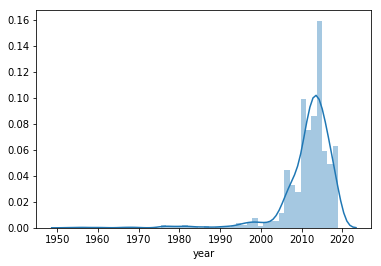

In [52]:
print('Year')
print('Mean   {}'.format(df['year'].mean()))
print('STD    {}'.format(df['year'].std()))
print('Median {}'.format(df['year'].median()))
print('IQR    {}'.format(scipy.stats.iqr(df['year'])))

print('Skewness {}'.format(scipy.stats.skew(df['year'])))
print('Kurtosis {}'.format(scipy.stats.kurtosis(df['year'])))
sns.distplot(df['year']);

Now lets see what are the most popular brands in our dataset

In [53]:
sorted_brands_by_sample_size = df.groupby('brand').size().sort_values(ascending=False)
most_popular_brands = sorted_brands_by_sample_size.where(sorted_brands_by_sample_size > 50).dropna()
display(most_popular_brands)

brand
Chevrolet        281.0
Renault          185.0
Ford             158.0
Toyota           156.0
Kia              156.0
Nissan           142.0
Volkswagen       121.0
Mazda            115.0
BMW              102.0
Hyundai           85.0
Mercedes Benz     79.0
Honda             51.0
Audi              51.0
dtype: float64

Now lets see the relation between **mileage**, **year** and **price** for the most popular brans

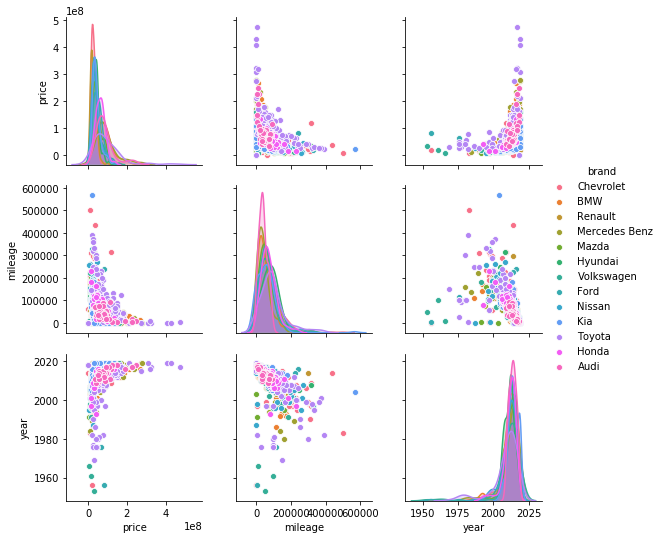

In [54]:
reduce_df = df[df['brand'].isin(most_popular_brands.index)]
sns.pairplot(data=reduce_df[['price', 'mileage', 'year', 'brand']], hue='brand')

In [55]:
price_mileage_cor, price_mileage_pv = scipy.stats.spearmanr(reduce_df['price'], reduce_df['mileage'])
price_year_cor, price_year_pv = scipy.stats.spearmanr(reduce_df['price'], reduce_df['year'])
mileage_year_cor, mileage_year_pv = scipy.stats.spearmanr(reduce_df['mileage'], reduce_df['year'])
print('Correlation between price and mileage is {} and its p-value {}'.format(price_mileage_cor, price_mileage_pv))
print('Correlation between price and year is {} and its p-value {}'.format(price_year_cor, price_year_pv))
print('Correlation between year and mileage is {} and its p-value {}'.format(mileage_year_cor, mileage_year_pv))

Correlation between price and mileage is -0.46949981908745286 and its p-value 5.955778200837827e-93
Correlation between price and year is 0.5089395163947074 and its p-value 1.6578577847305742e-111
Correlation between year and mileage is -0.8080309833565663 and its p-value 0.0


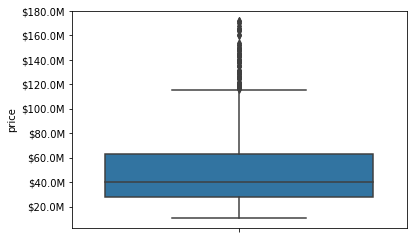

In [56]:
# removing outliers
over = reduce_df['price'].quantile(0.75) + 3*scipy.stats.iqr(reduce_df['price'])
under = reduce_df['price'].quantile(0.01) 
reduce_df = reduce_df[(reduce_df['price'] > under) & (reduce_df['price'] < over)]
ax = sns.boxplot(y='price', data=reduce_df);
ax.yaxis.set_major_formatter(formatter);

For the most popular brands of cars lets make a prediction of a price given the parameters that we have


In [251]:

display(reduce_df.isna().any())

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
imp = DataFrameImputer()
reduce_df_imp = imp.fit_transform(reduce_df)
reduce_df_imp.isna().any()


brand           False
color           False
fuel             True
mileage         False
model           False
onlyOwner        True
price           False
steering        False
traction         True
transmission    False
year            False
State           False
City            False
dtype: bool

brand           False
color           False
fuel            False
mileage         False
model           False
onlyOwner       False
price           False
steering        False
traction        False
transmission    False
year            False
State           False
City            False
dtype: bool

In [253]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

# brand           0 categorical
# color           1 categorical
# fuel            2 categorical
# mileage         3 numerical
# model           4 numerical
# onlyOwner       5 Binary
# price           6 numerical
# steering        7 categorical
# traction        8 Binary
# transmission    9 Binary
# year            10 numerical
# State           11 categorical
# City            12 categorical
display(reduce_df_imp.brand.unique())


categorical_columns = ['brand', 'color', 'fuel', 'steering']

# One-Hot-Encoding
new_dataset = pd.get_dummies(reduce_df_imp, columns=categorical_columns)

# MultiLabel Encoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
mcle = MultiColumnLabelEncoder(columns = ['onlyOwner', 'traction', 'transmission'])

new_dataset = mcle.fit_transform(new_dataset)

X = new_dataset.drop(columns=['price', 'model' ,'City', 'State'])
Y = reduce_df_imp['price'].values

array(['Chevrolet', 'BMW', 'Renault', 'Mercedes Benz', 'Mazda', 'Hyundai',
       'Ford', 'Nissan', 'Kia', 'Toyota', 'Volkswagen', 'Honda', 'Audi'],
      dtype=object)

Index(['mileage', 'onlyOwner', 'traction', 'transmission', 'year',
       'brand_Audi', 'brand_BMW', 'brand_Chevrolet', 'brand_Ford',
       'brand_Honda', 'brand_Hyundai', 'brand_Kia', 'brand_Mazda',
       'brand_Mercedes Benz', 'brand_Nissan', 'brand_Renault', 'brand_Toyota',
       'brand_Volkswagen', 'color_Amarillo', 'color_Anaranjado', 'color_Azul',
       'color_Beige', 'color_Blanco', 'color_Crema', 'color_Dorado',
       'color_Gris', 'color_Marrón', 'color_Negro', 'color_Otro',
       'color_Plateado', 'color_Rojo', 'color_Verde', 'color_Vinotinto',
       'fuel_Diesel', 'fuel_Gasolina', 'fuel_Gasolina y gas',
       'steering_Asistida', 'steering_Hidráulica', 'steering_Mecánica',
       'steering_Otro'],
      dtype='object')

Another element that we must be aware of, is that car manufacturers create diferent cars for diferent *sectors*, back in the day (the beaggining of car manufacturing), a manufacuter had one car and that was it, but as the market grow and the necesities of the people started changing, so did the cars, nowdays a manufacturer tries produces at least on car per **segment**, the reason to consider this is because it does not make any sence compare a truck with a sedan,that its way we are going to create a new variable from the data we have so far by pulling what we are missing from the internet.

Also why must considere that some cars are sold under diferent names and diferent brands depending on the market, take for example **Honda** wich sales some of their cars under the name of **Acura** in some markets in order to appeal to a diferent market.

In [ ]:
# Import exta libraries
import requests
from bs4 import BeautifulSoup
import unidecode
from fuzzywuzzy import fuzz

alternative_names = pd.DataFrame(
    columns=[
        'brand',
        'model',
        'search_brand',
        'search_model'
    ]
);

car_database = 'http://www.auto-data.net'

def fill_alternative_fields(brand, models):
    print('CALLED')
    req = requests.get(car_database + '/en/allbrands')
    soup = BeautifulSoup(req.content, 'lxml')
    brands_tags = soup.findAll('a', {'class': 'marki_blok'})
    brands = list(map(
        lambda x: {'name': x.text, 'link': x.attrs['href']},
        brands_tags
    ))
    similarity_brands = list(map(
        lambda x: fuzz.partial_ratio(x['name'], brand),
        brands
    ))
    
    most_likely_index_brand = np.argsort(similarity_brands)[-1]
    if (similarity_brands[most_likely_index_brand] < 90):
        print('No match for brand {}'.format(brand))
        
    most_likely_brand = brands[most_likely_index_brand]
    
    req_brand = requests.get(car_database + most_likely_brand['link'])
    soup_brand = BeautifulSoup(req_brand.content, 'lxml')
    car_tags = soup_brand.find_all('a', {'class': 'modeli'})
    cars = list(map(
        lambda x: {'name': x.span.text, 'link': x.get('href')}, 
        car_tags
    ))
    
    similarity_cars = list(map(
        lambda x: fuzz.partial_ratio(x['name'], models),
        cars
    ))
    
    most_likely_index_car = np.argsort(similarity_cars)[-1]
    most_likely_car = cars[most_likely_index_car]
    print(most_likely_car, models, similarity_cars[most_likely_index_car])
    

for index, row in df.iterrows():
    brand, model = row[['brand', 'model']]
    brand_model = alternative_names[
        (alternative_names['brand'] == brand) & 
        (alternative_names['model'] == model)
    ]
    if brand_model.empty:
        fill_alternative_fields(brand, model)
        # display(alternative_names)
    # car_info = car_info.append(get_data(brand, model, year))
    